In [76]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr
from imblearn.over_sampling import SMOTE
from scipy.cluster.hierarchy import linkage, dendrogram


In [77]:
# Path to local CSV file
file_path = 'Mushrooms.data.csv'

# Column names as per the dataset provided
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Load the dataset (with proper column names if the file doesn't include them)
df = pd.read_csv(file_path, sep=',', names=column_names, header=None)

# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8125 entries, 0 to 8124
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8125 non-null   object
 1   cap-shape                 8125 non-null   object
 2   cap-surface               8125 non-null   object
 3   cap-color                 8125 non-null   object
 4   bruises                   8125 non-null   object
 5   odor                      8125 non-null   object
 6   gill-attachment           8125 non-null   object
 7   gill-spacing              8125 non-null   object
 8   gill-size                 8125 non-null   object
 9   gill-color                8125 non-null   object
 10  stalk-shape               8125 non-null   object
 11  stalk-root                8125 non-null   object
 12  stalk-surface-above-ring  8125 non-null   object
 13  stalk-surface-below-ring  8125 non-null   object
 14  stalk-color-above-ring  

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-\r\nbelow-ring,stalk-color-\r\nabove-ring,stalk-color-\r\nbelow-ring,veil-type,veil-color,ring-number,ring-type,spore-print-\r\ncolor,population,habitat
1,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
2,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
3,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
4,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u


In [78]:
# Clean the 'class' column if necessary (standardizing 'poisonous' -> 'p' and 'edible' -> 'e')
df['class'] = df['class'].replace({'poisonous': 'p', 'edible': 'e'})

# Check the unique values in the 'class' column
print(df['class'].unique())

# Check if there are any missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Handle missing values by filling with mode
df = df.apply(lambda col: col.fillna(col.mode()[0]))



['p' 'e']
Missing values per column:
Series([], dtype: int64)


## Class Distribution (Edible vs Poisonous)
The plot below shows the distribution of the two classes in the dataset: edible and poisonous mushrooms.


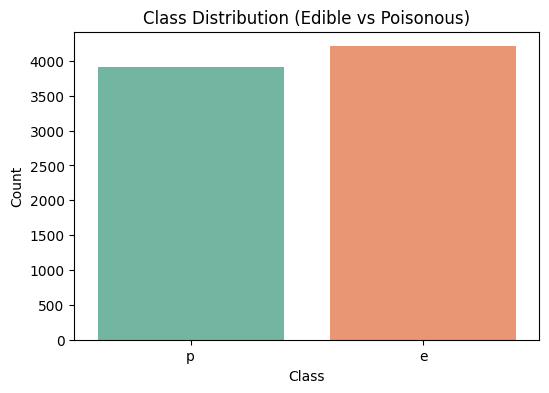

class
e    4208
p    3917
Name: count, dtype: int64


In [79]:
# 1. **Class Distribution (Edible vs Poisonous)**
# Class distribution (edible vs poisonous)
class_distribution = df['class'].value_counts()

# Plotting the class distribution (Edible vs Poisonous)
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df, hue='class', palette="Set2", legend=False)
plt.title('Class Distribution (Edible vs Poisonous)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display the class distribution count
print(class_distribution)


## Feature Distributions
The following plots show the distribution of the first few categorical features in the dataset. Each plot is separated by class (edible vs poisonous).

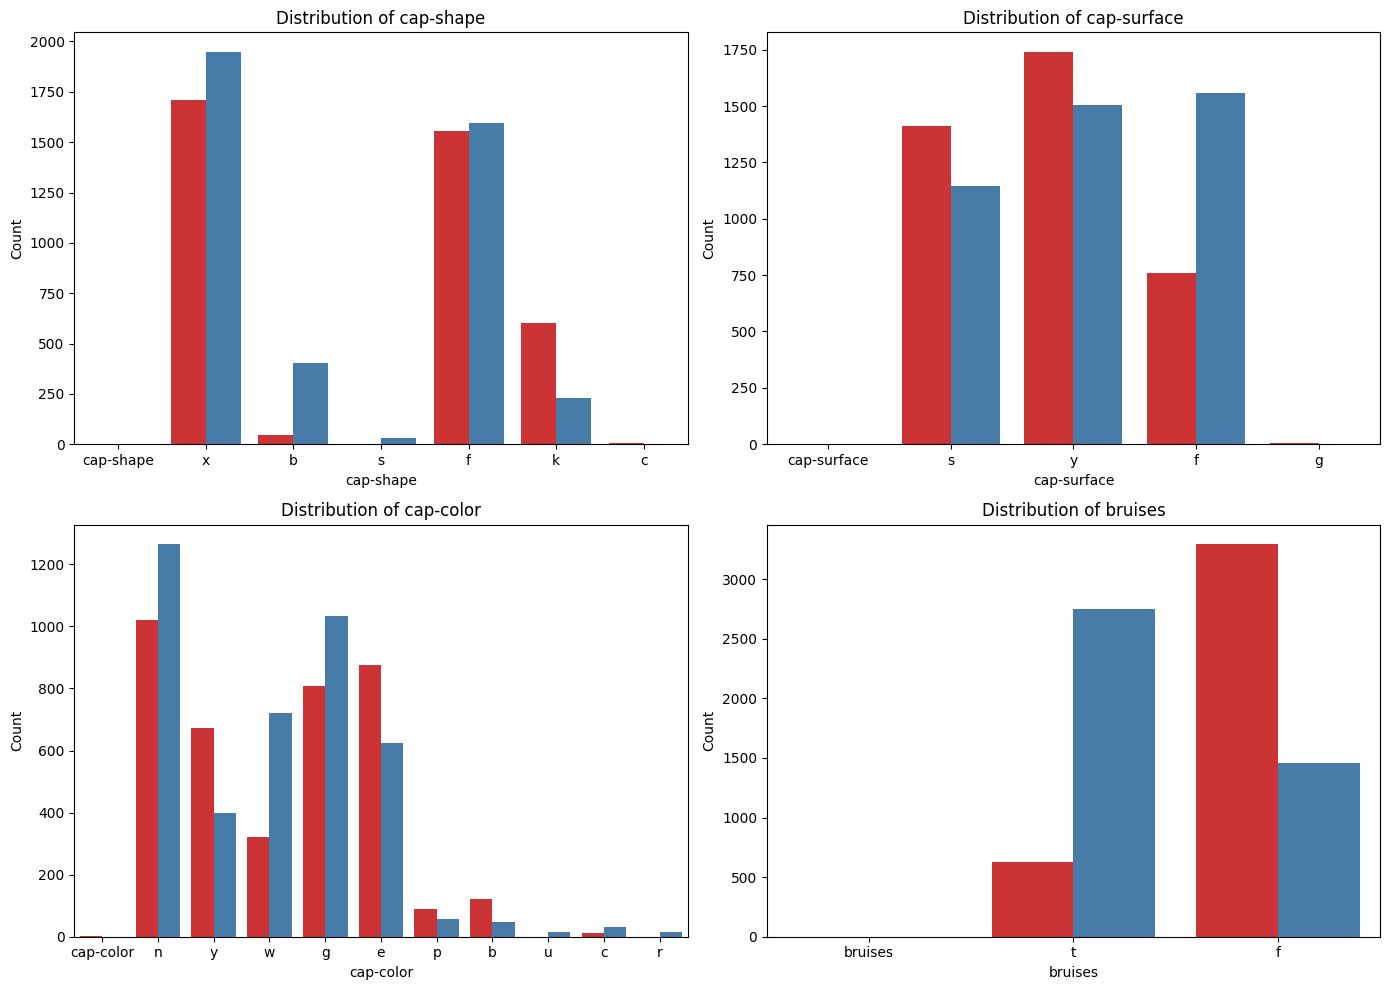

In [80]:
# Plot the distribution of the first few categorical features (to understand their distribution)
plt.figure(figsize=(14, 10))
for i, column in enumerate(df.columns[1:5]):  # Plotting the first 4 columns
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=column, data=df, hue='class', palette="Set1", legend=False)  # Updated line
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [81]:
# 4. **Calculate Point-Biserial Correlation between Features and Target (Class)**
# Convert target ('class') to binary values (1 for poisonous, 0 for edible)
df['class'] = df['class'].map({'p': 1, 'e': 0})

# Calculate point-biserial correlation for each feature with the target variable
correlations = []
for column in df.columns[1:]:  # Skip the target column ('class')
    # Encode each categorical feature using one-hot encoding
    feature = pd.get_dummies(df[column], drop_first=True)  # One-hot encoding
    for col in feature.columns:
        # Calculate the point-biserial correlation between the target and feature
        corr, _ = pointbiserialr(df['class'], feature[col])  # Point-biserial correlation
        correlations.append((column, col, corr))

# Convert the list of correlations to a DataFrame for easier viewing
corr_df = pd.DataFrame(correlations, columns=['Feature', 'Encoded Feature', 'Correlation'])

# Sort correlations by absolute value of correlation to get the most important ones
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Display the top correlated features
print("Top Correlations with Target (Poisonous Mushroom):")
print(corr_df.head())


Top Correlations with Target (Poisonous Mushroom):
                     Feature Encoded Feature  Correlation
23                      odor               f     0.623710
56  stalk-surface-above-ring               k     0.587523
60  stalk-surface-below-ring               k     0.573392
36                 gill-size               n     0.539888
20                   bruises               f     0.501303


## Top 10 Point-Biserial Correlations with Target (Poisonous Mushroom)
The bar plot below shows the top 10 features that have the highest point-biserial correlation with the target variable (poisonous mushroom).

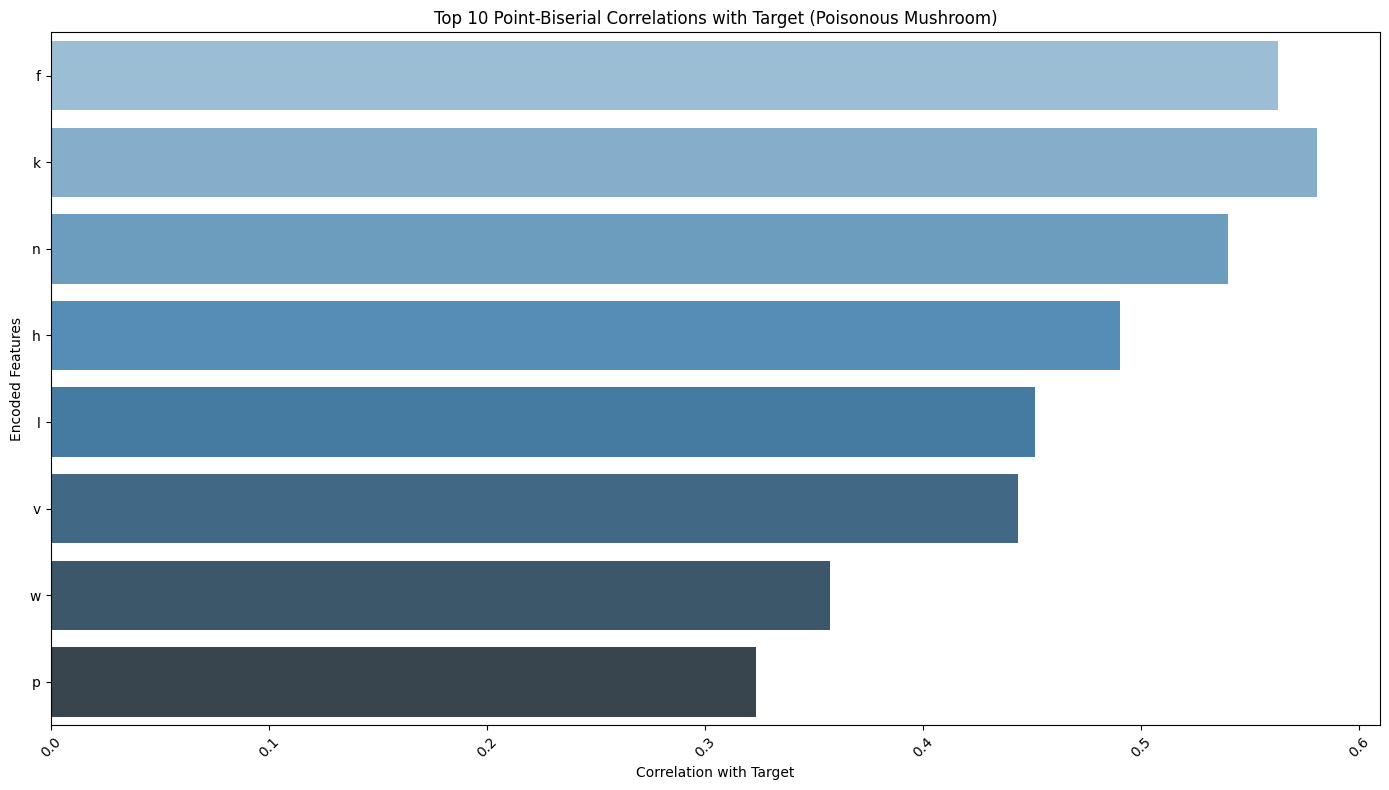

In [82]:
# 5. # Plotting the top 10 correlations with the target variable (Poisonous Mushroom)
top_corr_df = corr_df.head(10)  # Select top 10 most correlated features

plt.figure(figsize=(14, 8))  # Increase plot size for better readability
sns.barplot(x='Correlation', y='Encoded Feature', data=top_corr_df, hue='Encoded Feature', palette='Blues_d', dodge=False, errorbar=None, legend=False)
plt.title('Top 10 Point-Biserial Correlations with Target (Poisonous Mushroom)')
plt.xlabel('Correlation with Target')
plt.ylabel('Encoded Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [87]:
# Ensure all features are numeric and properly encoded before SMOTE
# Convert categorical features to one-hot encoded variables
X = pd.get_dummies(df.drop('class', axis=1), drop_first=True)
y = df['class']

# Convert any boolean columns to integers
X = X.astype(int)

# Verify the encoding
print(X.head())
print(y.head())

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the resampled class distribution
print(pd.Series(y_resampled).value_counts())



   cap-shape_c  cap-shape_cap-shape  cap-shape_f  cap-shape_k  cap-shape_s  \
0            0                    1            0            0            0   
1            0                    0            0            0            0   
2            0                    0            0            0            0   
3            0                    0            0            0            0   
4            0                    0            0            0            0   

   cap-shape_x  cap-surface_f  cap-surface_g  cap-surface_s  cap-surface_y  \
0            0              0              0              0              0   
1            1              0              0              1              0   
2            1              0              0              1              0   
3            0              0              0              1              0   
4            1              0              0              0              1   

   ...  population_s  population_v  population_y  habitat_g  h